# CVRP Notebook
This notebook is intended to run the top level code for the CVRP

In [1]:
import networkx as nx

from src.model import VRP, create_constraints, output_variables, create_example_2
from src.pricer import VRPPricer
from src.parse import parse
from src.output import write_solution

from matplotlib import pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# G = parse("E-n22-k4")
# G = parse("E-n23-k3")
# G = parse("E-n30-k3")
G = parse("E-n33-k4")
# G = parse("E-n51-k5")
# G = parse("E-n76-k14",filename="output/E-n76-k14.debug")
# G = parse("E-n101-k14",filename="output/E-n101-k14.debug")
# G = parse("Instances/Uchoa/X-n101-k25.vrp")
# G.graph['min_trucks'] = 26
# G = parse("Instances/Uchoa/X-n106-k14.vrp")
# G.graph['min_trucks'] = 14
# G = parse("Instances/Uchoa/X-n110-k13.vrp")
# G.graph['min_trucks'] = 13
# G = parse("Instances/Uchoa/X-n115-k10.vrp")
# G.graph['min_trucks'] = 10
# G = parse("X-n120-k6",6)
# G = parse("Instances/Uchoa/X-n125-k30.vrp")
# G.graph['min_trucks'] = 30
# G = parse("Instances/Uchoa/X-n129-k18.vrp")
# G.graph['min_trucks'] = 18
# G = parse("Instances/Uchoa/X-n200-k36.vrp")
# G.graph['min_trucks'] = 36
# G = parse("Instances/Uchoa/X-n228-k23.vrp")
# G.graph['min_trucks'] = 23
# G = parse("Instances/Uchoa/X-n251-k28.vrp")
# G.graph['min_trucks'] = 28
# G = parse("Instances/Uchoa/X-n256-k16.vrp")
# G.graph['min_trucks'] = 16
# G = parse("Instances/Uchoa/X-n289-k60.vrp")
# G.graph['min_trucks'] = 61
# G = parse("Instances/Uchoa/X-n502-k39.vrp")
# G.graph['min_trucks'] = 39 #TODO: Ist dieses K auch das K, einer Optimallösung?

MAIN: Instance E-n33-k4
PARSE: Minimum number of trucks is 4
PARSE: Writing to file output/E-n33-k4_2.log


In [ ]:
model = VRP(G)

# Create pricer
pricer = VRPPricer(G)
pricer.data['methods'] = ["ng20"]
pricer.data["ESPPRC_heur"] = True
pricer.data['max_vars']= int(1e4)
pricer.data['time_limit'] = 11000
pricer.data['farley'] = False

model.includePricer(pricer, "pricer","does pricing")

create_constraints(model,pricer,heuristic_stale_it=20, heuristic_max_it=2e3, heuristic_time=1e-2)

model.optimize()
model.hideOutput(quiet=False)

write_solution(model, pricer)

HYGESE: Found 14 initial routes in 39 rounds. Best sol val is 835.0
SETUP: methods are ['ng20']
SETUP: time_limit is 11000
SETUP: Farley is False
PRICER_PY: The maximal path length is 136
PRICER_PY: The neighborhood has been initialzied to [20, 20] neighbors.
PRICER_C: Graph data successfully copied to C.
presolving:
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 46 variables (0 bin, 0 int, 0 impl, 46 cont) and 33 constraints
     33 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
* 0.1s|     1 |     0 |     9 |     - |    LP  |   0 |  46 |  33 |  33 |   0 |  0 |   0 |   0 |      --      | 8.350000e+02 |    Inf | unknown
  0.1s|     1 |     0 |    23 |

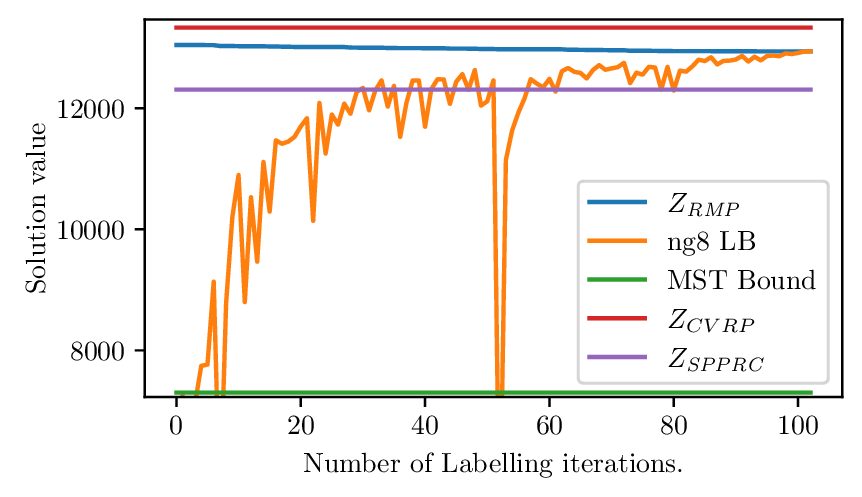

In [61]:
# This value is nice looking for the standard latex layout
# plt.figure(figsize=(6.6,4),dpi=100)

This value is nice looking for the CoAn layout
plt.figure(figsize=(7.3,4),dpi=200)

# This value is the original value for the presentation but looks horrible
# plt.figure(figsize=(4.5,2.5),dpi=200)

upper_bounds = [x for x,y in pricer.data['bounds'][pricer.data['methods'][0]]]
plt.plot(upper_bounds, label="$Z_{\mathit{RMP}}$")

xmax = 0
for method in pricer.data['methods']:
    lower_bounds = [lb for _,lb in pricer.data['bounds'][method]]
#     lower_bounds = []
#     best_lb = pricer.data['bounds'][method][0][1]
#     for x,y in pricer.data['bounds'][method]:
#         if y > best_lb:
#             best_lb = y
#         lower_bounds.append(best_lb)
    plt.plot(lower_bounds, label=f'{method} LB')
    xmax = max(upper_bounds[0],xmax)

T = nx.minimum_spanning_tree(G)
K = G.graph['min_trucks']
lowest_remaining_edge_weights = [weight for u,v,weight in G.edges().data('weight') if not T.has_edge(u,v)]
mst = T.size(weight='weight') + sum(sorted(lowest_remaining_edge_weights)[:K])
mst = [mst for i in range(len(upper_bounds))]
plt.plot(mst, label="MST Bound")

optimal = [13332 for i in range(len(upper_bounds))]
plt.plot(optimal, label="$Z_{CVRP}$")

spprc = [12308 for i in range(len(upper_bounds))]
plt.plot(spprc, label="$Z_{\mathit{SPPRC}}$")

# ng8 = [481 for i in range(len(upper_bounds))]
# plt.plot(ng8, label="Optimal value of ng 8.")

# cyc2 = [12784 for i in range(len(upper_bounds))]
# plt.plot(cyc2, label="$Z_{\mathit{2-cycle}}$")

if pricer.data['farley']:
    farley_bounds = pricer.data['farley_bound']
    plt.plot(farley_bounds, label="Farley Bound")

# solval = model.getObjVal()
# sol = [solval for i in range(len(upper_bounds))]
# plt.plot(sol,label="$Z_{MP}")

plt.ylim((mst[0]*0.99,optimal[0]*1.01))

plt.legend(loc='lower right')
plt.xlabel("Number of Labelling iterations.")
plt.ylabel("Solution value")
plt.savefig("plots/X-n120-k6.ng8-fluctuations-presentation.pgf")
# plt.show()

In [5]:
output_variables(model, pricer)

The solution contains the following paths: 
Only paths with associated value larger than 1e-06 are analysed.
Solution contains only elementary paths.
